In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from src.models.frontier import MultiStockEnv, Agent, backtest, maybe_make_dir
from src.config import market_tickers
from src.config.model_config import model_parameters

CPU times: user 1.13 s, sys: 93.6 ms, total: 1.22 s
Wall time: 1.48 s


In [2]:
# papermill parameters
SEED_LIST = [0] # only works for one value as it is now

#TICKERS = market_tickers.NIK_25_TICKER
TICKERS = ['AAPL', 'AMD', 'CSCO', 'F', 'INTC']
MARKET_NAME = 'TEST_5'
MODEL_BASE_NAME = 'RL_CNN' # use either | 'RL_CNN' | 'RL_str_fcast' | 'RL_all_inp' |
FROM = '2019-01-01' # start of backtest
UNTIL = '2020-01-01' # end of backtest
NB_EPISODES = 200 # backtest model that was trained for this number of episodes

In [3]:
# other constants and parameters
TICKERS.sort()
FILE_PERIOD = '1d' # weekly='5d', daily='1d'
HALF_SPREAD = 0.0005/2.0 # 'a' in transaction cost function
NONLIN_COEFF = 1.0 # 'b' transaction cost function
POWER = 1.5 # power for change in poertfolio vector used in transaction cost
INIT_PORTFOLIO = 100000000.0 # initial portfolio value

USE_FORECASTS = model_parameters[MODEL_BASE_NAME]['use_forecasts'] # whether to use forecasts as inputs to agent policy net or not
NB_FORECASTS = model_parameters[MODEL_BASE_NAME]['nb_forecasts'] # number of forecasts to use in state. Set to None for no forecasts
FORECAST_TYPE = model_parameters[MODEL_BASE_NAME]['forecast_type'] # use 'strong' or 'weak' forecasts (if no forecasts given, this does not matter)
USE_CNN_STATE = model_parameters[MODEL_BASE_NAME]['use_cnn_state'] # whether to pass log-rets block for CNN part of policy net (set to false for forecast only)

TEST_NAME = f'{MARKET_NAME}_{MODEL_BASE_NAME}_seeds_{SEED_LIST[0]}_etc'
RESULTS_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/backtests/'
DATA_DIR = f'../data/{MARKET_NAME}/preprocessed_data/'

In [4]:
#frontier_df = pd.read_csv(f'{RESULTS_DIR}{MARKET_NAME}_{MODEL_BASE_NAME}_seed_frontiers.csv')
frontier_df = pd.read_csv(f'{RESULTS_DIR}{MARKET_NAME}_{MODEL_BASE_NAME}_seeds_{SEED_LIST[0]}_etc.csv')
frontier_df = frontier_df[frontier_df['seed']==SEED_LIST[0]]
frontier_df.head()

gamma_trade  gamma_risk  gamma_hold  seed  excess_return  excess_risk  \
0          0.1         0.1         0.1     0      27.187393    17.610814   
1          0.1         1.0         0.1     0      44.261488    27.189715   
2          0.1        18.0         0.1     0      -1.096900    13.432626   
3          0.1        56.0         0.1     0      10.262414    13.141272   
4          0.1       100.0         0.1     0       9.700907    13.518217   

     sharpe  
0  1.543790  
1  1.627876  
2 -0.081659  
3  0.780930  
4  0.717617

In [5]:
def make_int(x):
    if x.is_integer():
        x = int(x)
    return x

In [6]:
gamma_trade_list = [make_int(i) for i in list(frontier_df['gamma_trade'].round(3))]
gamma_risk_list = [make_int(j) for j in list(frontier_df['gamma_risk'].round(3))]
gamma_hold_list = [make_int(k) for k in list(frontier_df['gamma_hold'].round(3))]

GAMMA_TRIPPPLES = list(zip(gamma_trade_list, gamma_risk_list, gamma_hold_list))
#GAMMA_PAIRS

######### remove later ##########
# this is just to test a small set
#GAMMA_PAIRS = GAMMA_PAIRS[3:5]
GAMMA_TRIPPPLES
#################################

[(0.1, 0.1, 0.1),
 (0.1, 1, 0.1),
 (0.1, 18, 0.1),
 (0.1, 56, 0.1),
 (0.1, 100, 0.1),
 (0.1, 562, 0.1),
 (0.1, 1000, 0.1),
 (1, 0.1, 0.1),
 (1, 1, 0.1),
 (1, 18, 0.1),
 (1, 56, 0.1),
 (1, 100, 0.1),
 (1, 562, 0.1),
 (1, 1000, 0.1),
 (10, 0.1, 0.1),
 (10, 1, 0.1),
 (10, 18, 0.1),
 (10, 56, 0.1),
 (10, 100, 0.1),
 (10, 562, 0.1),
 (10, 1000, 0.1),
 (60, 0.1, 0.1),
 (60, 1, 0.1),
 (60, 18, 0.1),
 (60, 56, 0.1),
 (60, 100, 0.1),
 (60, 562, 0.1),
 (60, 1000, 0.1),
 (100, 0.1, 0.1),
 (100, 1, 0.1),
 (100, 18, 0.1),
 (100, 56, 0.1),
 (100, 100, 0.1),
 (100, 562, 0.1),
 (100, 1000, 0.1)]

In [7]:
print('number of pairs: ', len(GAMMA_TRIPPPLES))
#GAMMA_PAIRS

number of pairs:  35


## create agent(s) and backtest in new backtest env

In [8]:
%%time
# make directory for results if it does not exist already
maybe_make_dir(RESULTS_DIR)

print('creating environment and agent...')
env = MultiStockEnv(tickers=TICKERS, 
                    from_date=FROM,
                    until=UNTIL, 
                    #nb_episodes=100,
                    cash_key='USDOLLAR', 
                    #gamma_risk=GAMMA_RISK, 
                    #gamma_trade=GAMMA_TRADE,
                    #half_spread=HALF_SPREAD, 
                    nonlin_coef=NONLIN_COEFF, 
                    power=POWER, 
                    datadir=DATA_DIR, 
                    state_lookback_window=20, 
                    #distribution=EPISODE_DRAW_DISTRIBUTION,
                    #days_duration=DAYS_IN_EPISODE, 
                    mode='backtest', 
                    random_seed=7,
                    init_portfolio=INIT_PORTFOLIO, 
                    period_in_file_name=FILE_PERIOD, 
                    nb_forecasts=NB_FORECASTS, 
                    forecast_type=FORECAST_TYPE,
                    use_CNN_state=USE_CNN_STATE,
                    verbose=False)

agent = Agent(alpha=0.001, 
              gamma=0.99, 
              n_assets=len(TICKERS)+1, 
              tau=5, 
              lookback_window=20, 
              n_feature_maps=len(TICKERS)+1,
              use_forecasts=USE_FORECASTS,
              use_CNN_state=USE_CNN_STATE,
              allow_long_short_trades=True)

results_dict = {}
#actions_dict = {}
print('backtesting:')

total_backtests = len(SEED_LIST) * len(GAMMA_TRIPPPLES)
backtest_counter = 0

for RANDOM_SEED in SEED_LIST:
    for (GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD) in GAMMA_TRIPPPLES:
        
        backtest_counter += 1
        print(f'\t[{backtest_counter}/{total_backtests}]\t{MODEL_BASE_NAME}: gamma_trade={GAMMA_TRADE}, gamma_risk={GAMMA_RISK}, gamma_hold={GAMMA_HOLD}, seed={RANDOM_SEED}...')
        
        # load trained RL model for backtesting
        SAVED_MODEL_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}/models/{MODEL_BASE_NAME}_seed_{RANDOM_SEED}_{NB_EPISODES}'
        # set dir where actions csv file will be saved
        actions_dir = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}'
        
        try:
            rl_rets, rl_actions = backtest(agent, env, weights_file_dir=SAVED_MODEL_DIR, verbose=False)
            
            #rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[1:].index)
            #rl_actions = pd.DataFrame(data=rl_actions, index=env.returns.loc[FROM:UNTIL].iloc[0:].index, columns=TICKERS+['USDOLLAR'])
            rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[:-1].index)
            rl_rets = rl_rets.shift(1)
            rl_rets.iloc[0] = 0
            rl_actions = pd.DataFrame(data=rl_actions[:-1], index=env.returns.loc[FROM:UNTIL].iloc[:-1].index, columns=TICKERS+['USDOLLAR'])
            
            #print(f'rets: {rl_rets.shape}')
            #print(f'actions: {rl_actions.shape}')            
            
            # save actions
            rl_actions.to_csv(f'{actions_dir}/actions.csv')
            #print('actions saved.')

            cash_rets = env.returns.loc[FROM:UNTIL, env.cash_key].iloc[:-1]
            excess_rets = rl_rets - cash_rets

            R_e = excess_rets.mean() * 100 * 252
            sigma_e = excess_rets.std() * 100 * np.sqrt(252)
            sharpe = R_e / sigma_e

            results_dict[(GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD, RANDOM_SEED)] = {'excess_return':R_e, 'excess_risk':sigma_e, 'sharpe':sharpe}
        except Exception as e:
            print(f'**error for model: trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}')
            print(e)

creating environment and agent...
backtesting:
	[1/35]	RL_CNN: gamma_trade=0.1, gamma_risk=0.1, gamma_hold=0.1, seed=0...
	[2/35]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=0.1, seed=0...
	[3/35]	RL_CNN: gamma_trade=0.1, gamma_risk=18, gamma_hold=0.1, seed=0...
	[4/35]	RL_CNN: gamma_trade=0.1, gamma_risk=56, gamma_hold=0.1, seed=0...
	[5/35]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=0.1, seed=0...
	[6/35]	RL_CNN: gamma_trade=0.1, gamma_risk=562, gamma_hold=0.1, seed=0...
	[7/35]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=0.1, seed=0...
	[8/35]	RL_CNN: gamma_trade=1, gamma_risk=0.1, gamma_hold=0.1, seed=0...
	[9/35]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=0.1, seed=0...
	[10/35]	RL_CNN: gamma_trade=1, gamma_risk=18, gamma_hold=0.1, seed=0...
	[11/35]	RL_CNN: gamma_trade=1, gamma_risk=56, gamma_hold=0.1, seed=0...
	[12/35]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=0.1, seed=0...
	[13/35]	RL_CNN: gamma_trade=1, gamma_risk=562, gamma_hold=0.1, see

In [9]:
results_df = pd.DataFrame(results_dict).T.reset_index()
results_df.columns = ['gamma_trade', 'gamma_risk', 'gamma_hold', 'seed', 'excess_return', 'excess_risk', 'sharpe']
#results_df.to_csv(RESULTS_DIR+TEST_NAME+'.csv', index=False)
#print('saved.')
results_df

gamma_trade  gamma_risk  gamma_hold  seed  excess_return   excess_risk  \
0           0.1         0.1         0.1     0   2.718739e+01  1.761081e+01   
1           0.1         1.0         0.1     0   4.426149e+01  2.718972e+01   
2           0.1        18.0         0.1     0  -1.096900e+00  1.343263e+01   
3           0.1        56.0         0.1     0   1.026241e+01  1.314127e+01   
4           0.1       100.0         0.1     0   9.700907e+00  1.351822e+01   
5           0.1       562.0         0.1     0   2.253368e+01  1.490764e+01   
6           0.1      1000.0         0.1     0  -2.388960e+00           NaN   
7           1.0         0.1         0.1     0   2.554803e+01  1.795613e+01   
8           1.0         1.0         0.1     0  -2.388960e+00           NaN   
9           1.0        18.0         0.1     0   8.699633e-01  1.342654e+01   
10          1.0        56.0         0.1     0   7.638130e+00  1.263926e+01   
11          1.0       100.0         0.1     0   1.720575e+01  1.454079e+01   
12          1.0       562.0         0.1     0  -2.045143e+06  1.838008e+06   
13          1.0      1000.0         0.1     0   1.099307e+03  1.303712e+03   
14         10.0         0.1         0.1     0   5.236303e+01  3.570033e+01   
15         10.0         1.0         0.1     0   5.701282e+01  4.200858e+01   
16         10.0        18.0         0.1     0   6.883050e+00  1.332741e+01   
17         10.0        56.0         0.1     0   1.646419e+00  1.188904e+01   
18         10.0       100.0         0.1     0   1.487275e+01  1.379400e+01   
19         10.0       562.0         0.1     0   2.189887e+01  1.507731e+01   
20         10.0      1000.0         0.1     0  -1.409554e+05  9.798526e+04   
21         60.0         0.1         0.1     0   5.818763e+01  3.227894e+01   
22         60.0         1.0         0.1     0   4.751109e+01  2.534238e+01   
23         60.0        18.0         0.1     0   1.719441e+01  1.441561e+01   
24         60.0        56.0         0.1     0   1.095912e+01  1.336226e+01   
25         60.0       100.0         0.1     0   9.688372e+00  1.287096e+01   
26         60.0       562.0         0.1     0   2.074138e+01  1.498279e+01   
27         60.0      1000.0         0.1     0   2.148338e+01  1.509701e+01   
28        100.0         0.1         0.1     0   4.925072e+01  2.637698e+01   
29        100.0         1.0         0.1     0   4.408685e+01  2.375362e+01   
30        100.0        18.0         0.1     0   1.976268e+01  1.480667e+01   
31        100.0        56.0         0.1     0   1.279657e+01  1.368215e+01   
32        100.0       100.0         0.1     0   1.069903e+01  1.337072e+01   
33        100.0       562.0         0.1     0   1.446097e+01  1.372026e+01   
34        100.0      1000.0         0.1     0   2.190140e+01  1.551794e+01   

      sharpe  
0   1.543790  
1   1.627876  
2  -0.081659  
3   0.780930  
4   0.717617  
5   1.511552  
6        NaN  
7   1.422802  
8        NaN  
9   0.064794  
10  0.604318  
11  1.183275  
12 -1.112695  
13  0.843213  
14  1.466738  
15  1.357171  
16  0.516458  
17  0.138482  
18  1.078204  
19  1.452439  
20 -1.438537  
21  1.802650  
22  1.874768  
23  1.192764  
24  0.820155  
25  0.752731  
26  1.384347  
27  1.423023  
28  1.867186  
29  1.856006  
30  1.334714  
31  0.935275  
32  0.800183  
33  1.053987  
34  1.411360

In [10]:
rl_rets

Date
2019-01-02    0.000000
2019-01-03   -0.001412
2019-01-04   -0.034220
2019-01-07    0.034322
2019-01-08    0.013025
                ...   
2019-12-23    0.002220
2019-12-24    0.006589
2019-12-26    0.000835
2019-12-27    0.002912
2019-12-30   -0.003141
Length: 251, dtype: float32

In [11]:
cash_rets

Date
2019-01-02    0.000095
2019-01-03    0.000094
2019-01-04    0.000095
2019-01-07    0.000096
2019-01-08    0.000096
                ...   
2019-12-23    0.000062
2019-12-24    0.000062
2019-12-26    0.000062
2019-12-27    0.000062
2019-12-30    0.000062
Name: USDOLLAR, Length: 251, dtype: float64

In [12]:
# # example of actions plot
# rl_actions.plot(figsize=(10,4), title=r'Portfolio evolution: $\gamma^{risk}=$'+f'{GAMMA_RISK}'+r'; $\gamma^{trade}=$'+f'{GAMMA_TRADE}'+r'; $\gamma^{hold}=$'+f'{GAMMA_HOLD}')
# plt.ylabel('Asset weight')

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

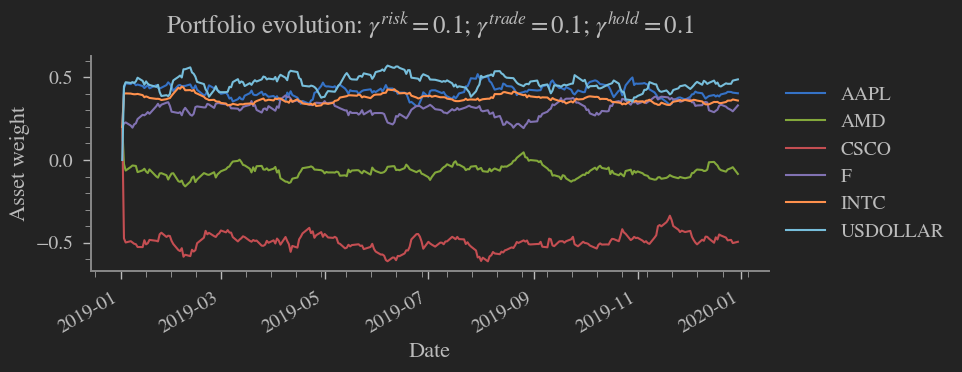

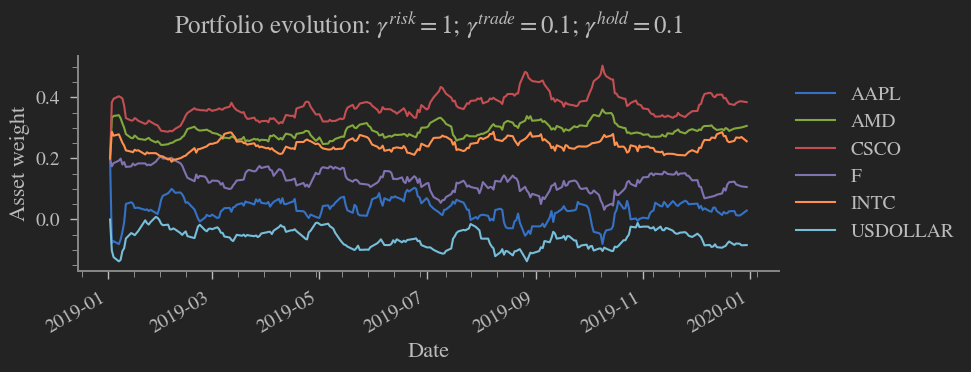

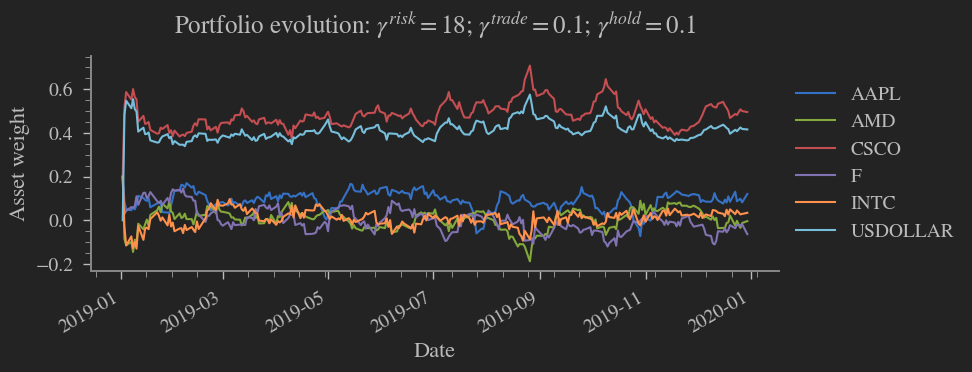

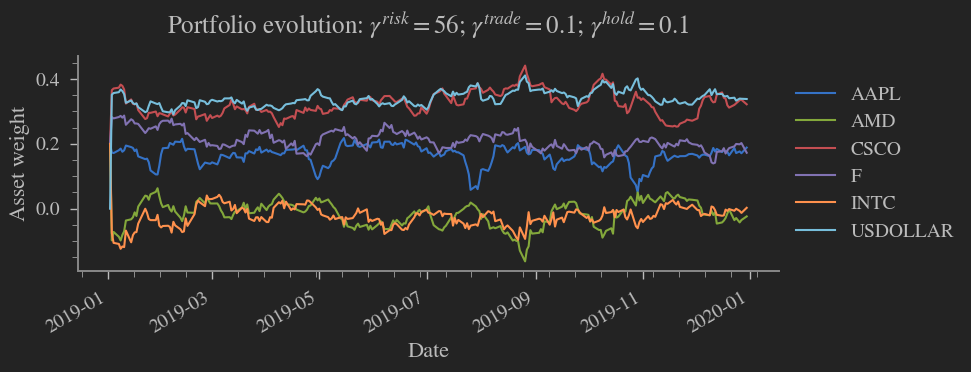

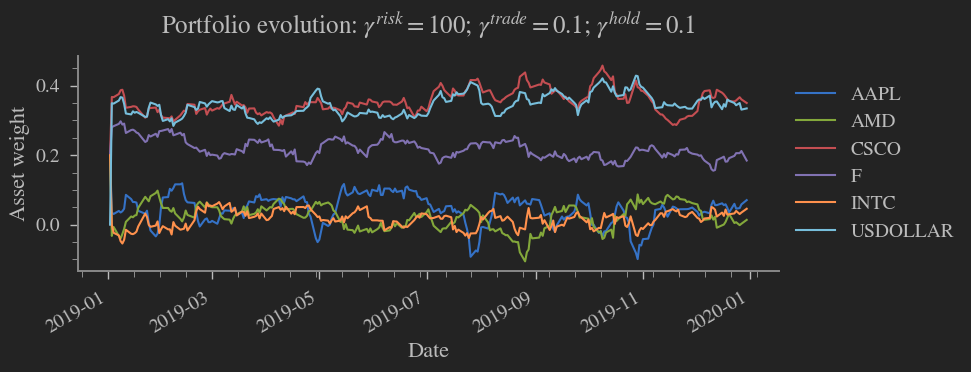

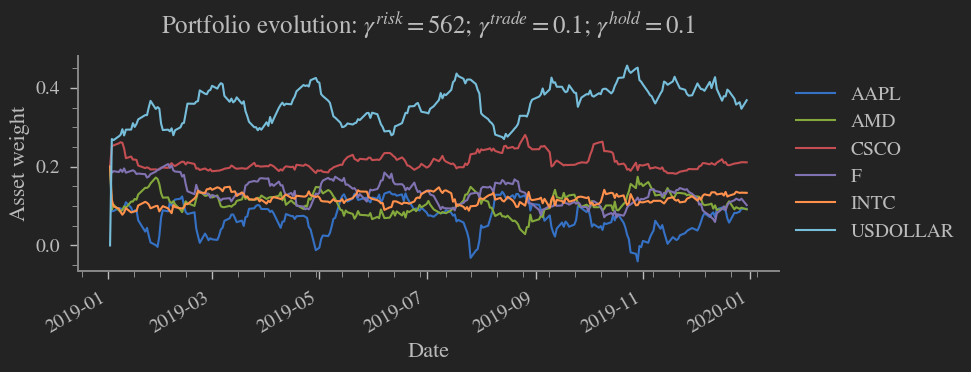

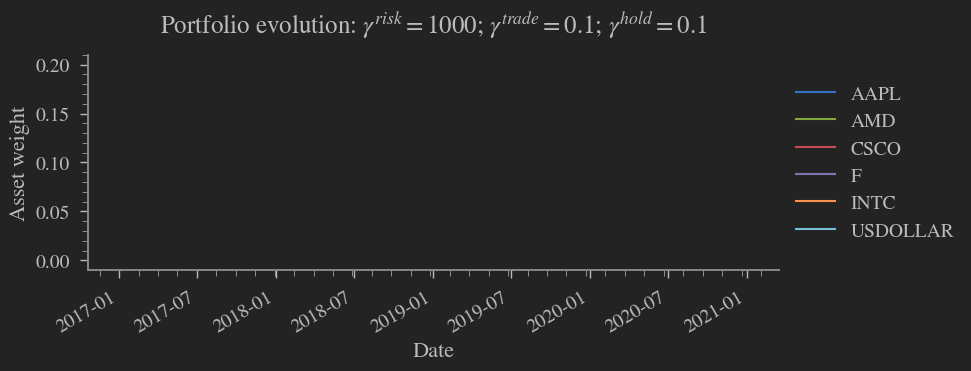

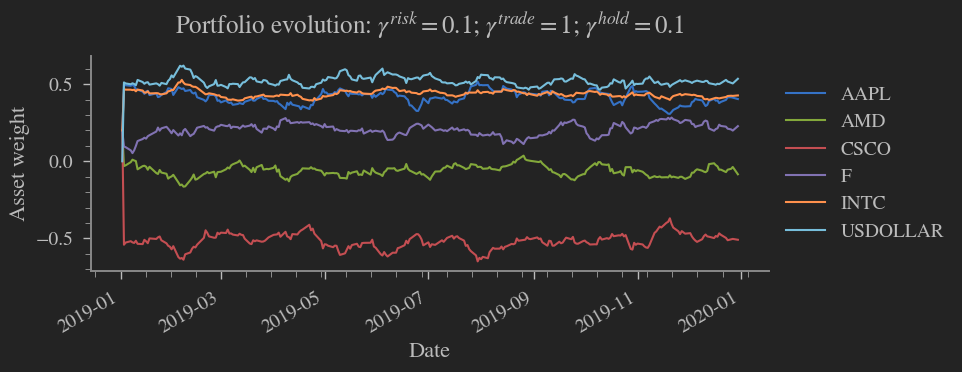

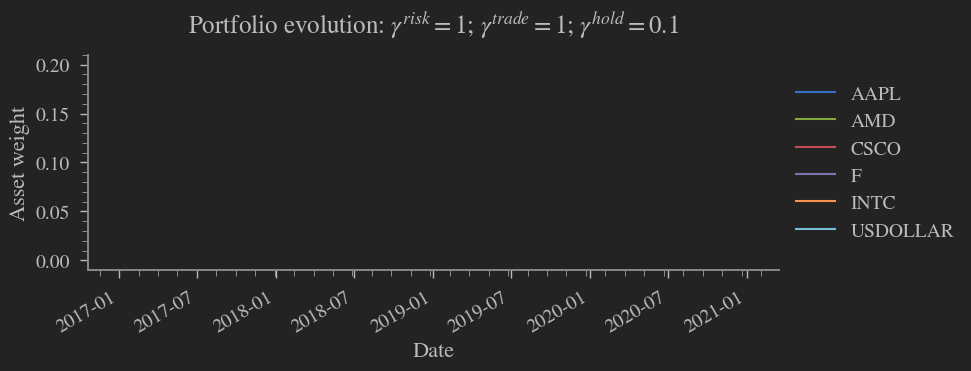

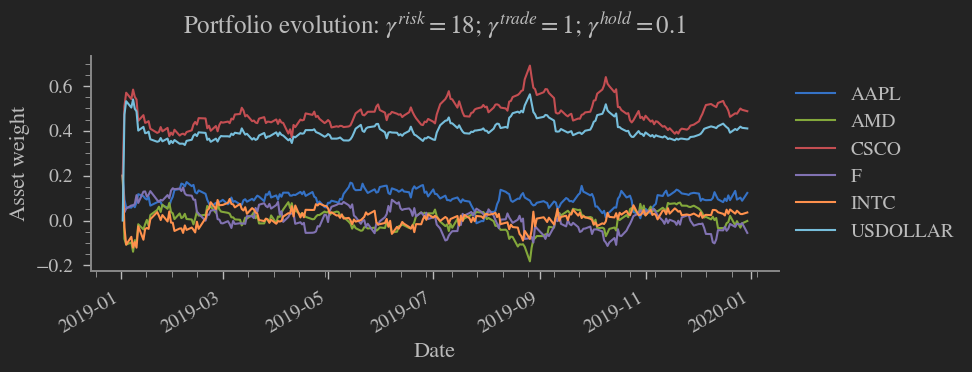

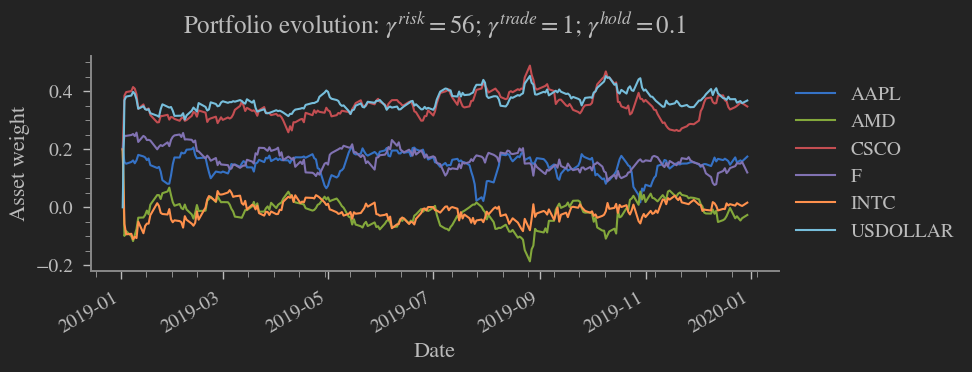

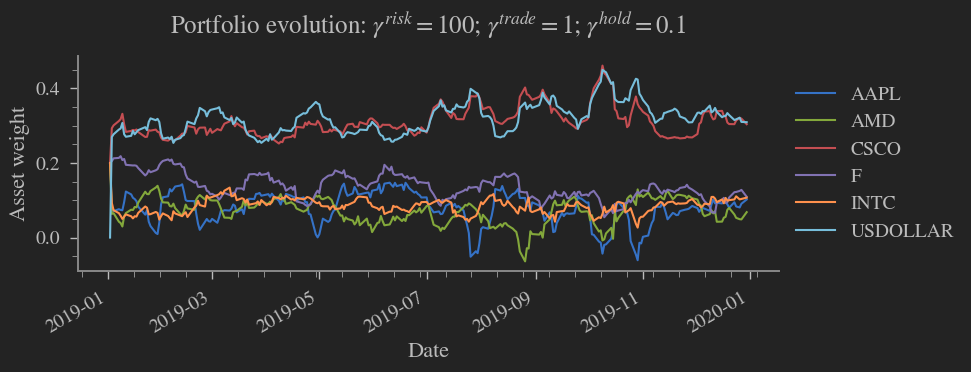

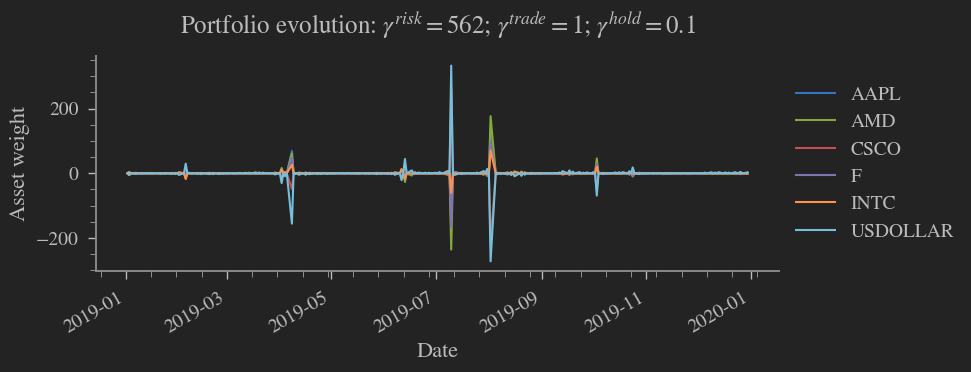

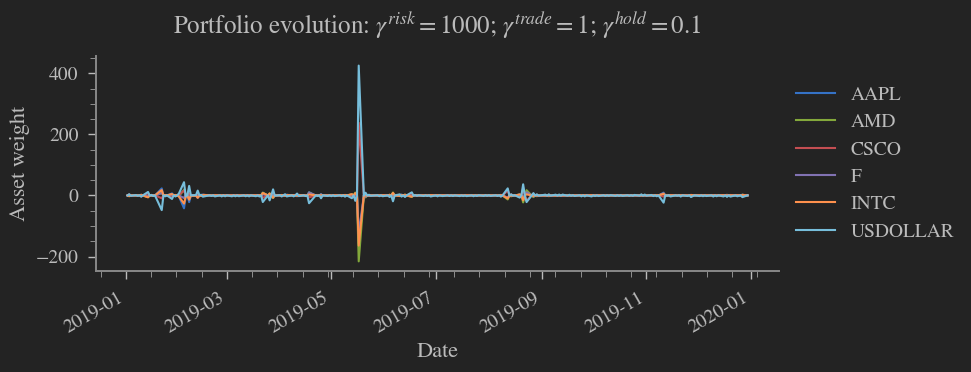

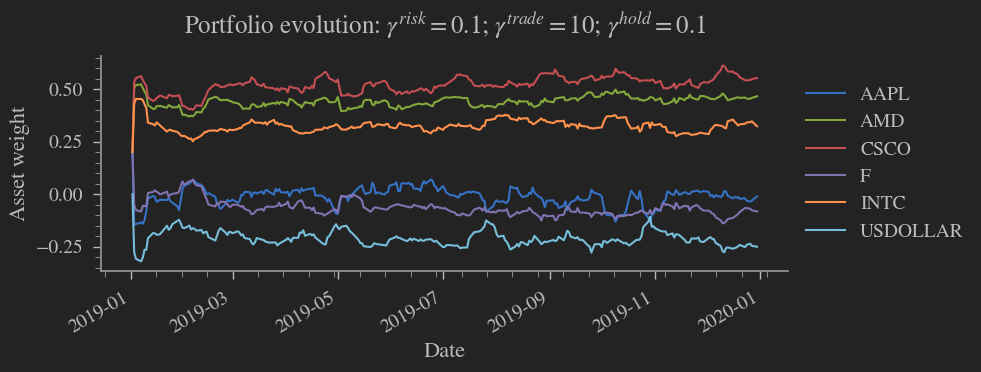

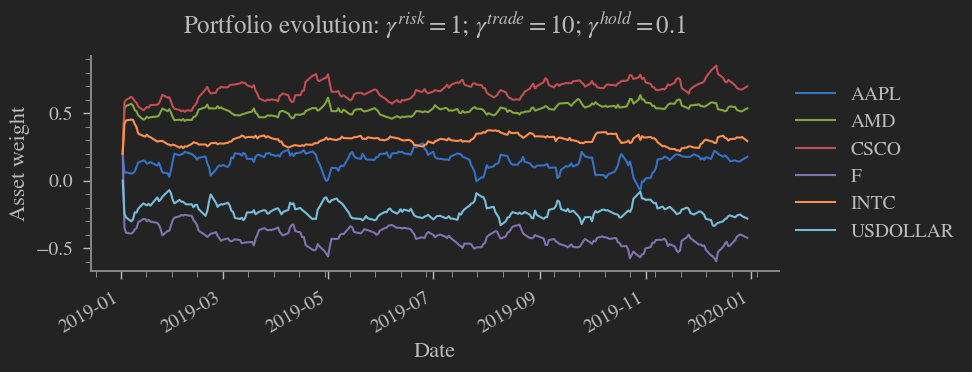

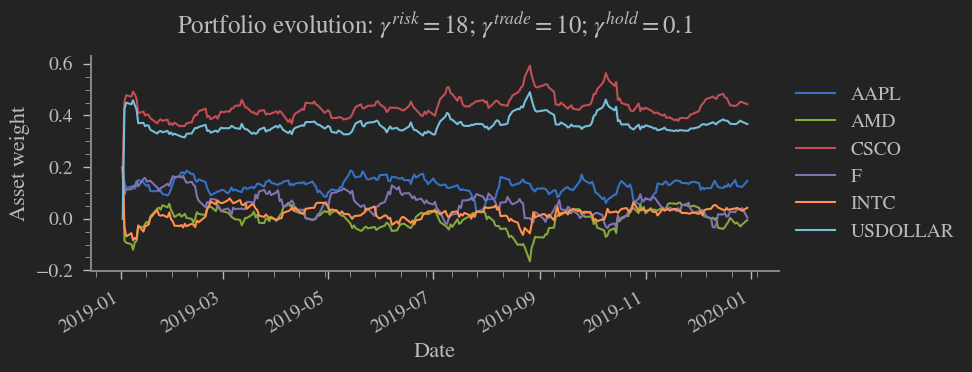

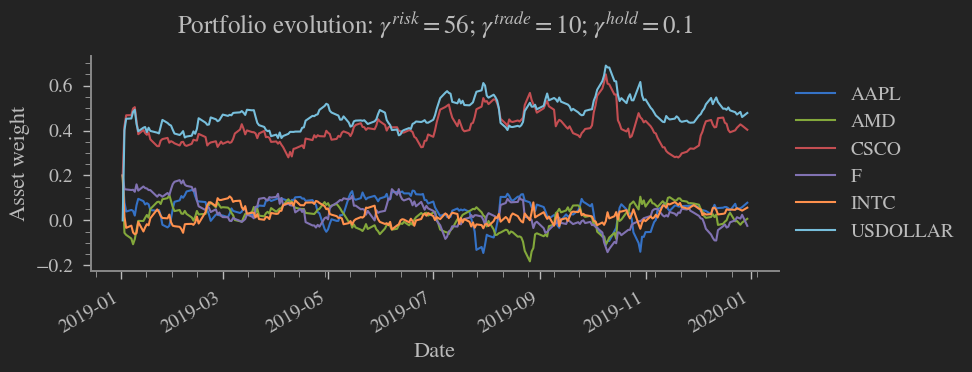

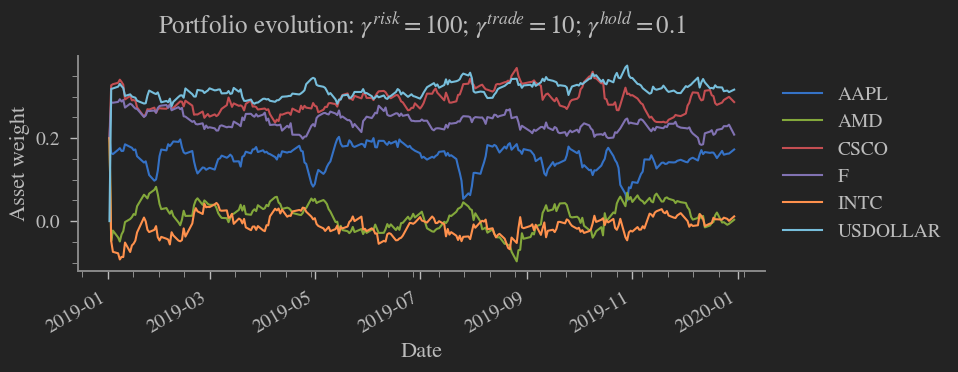

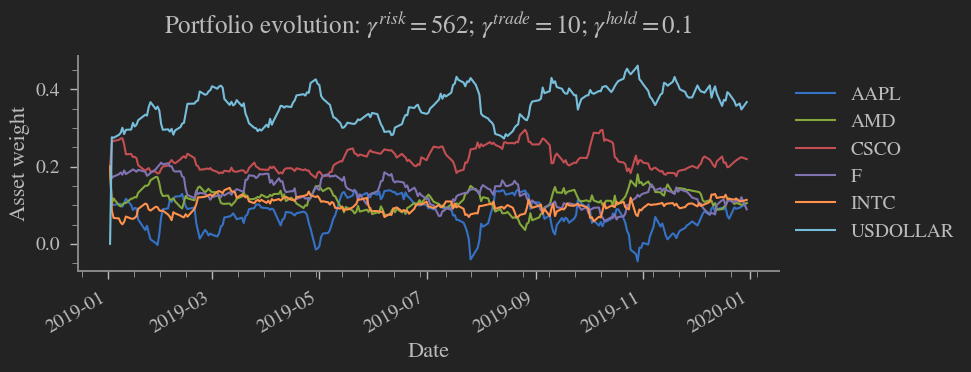

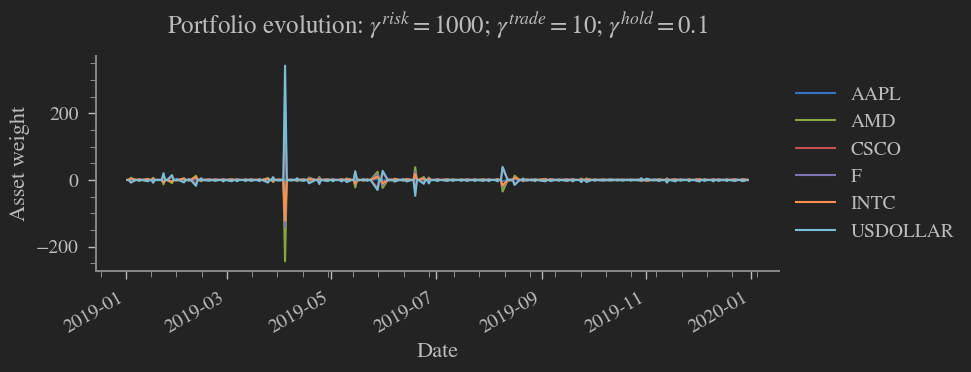

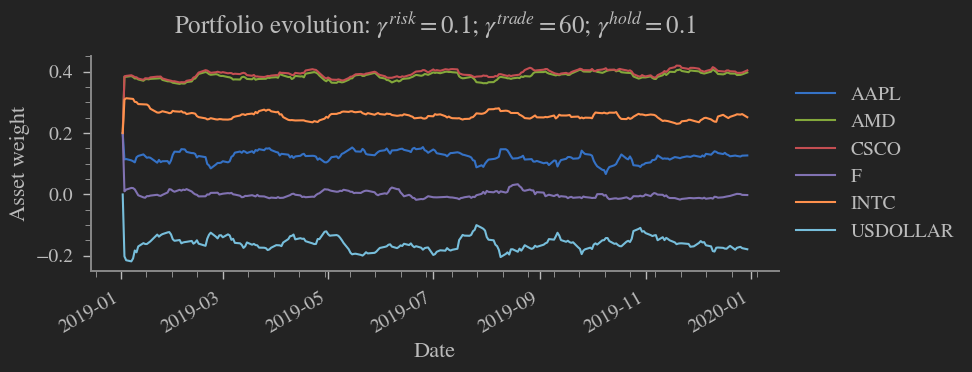

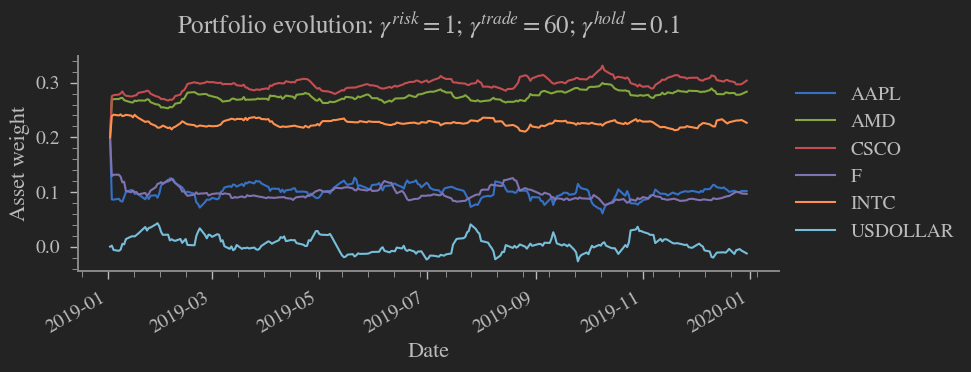

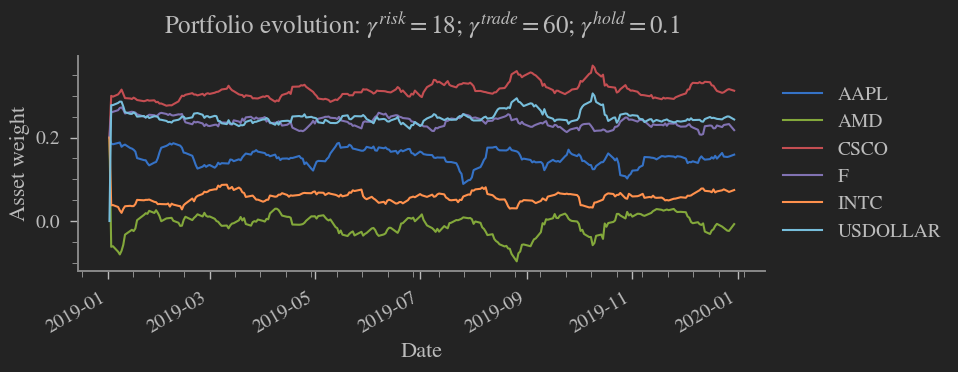

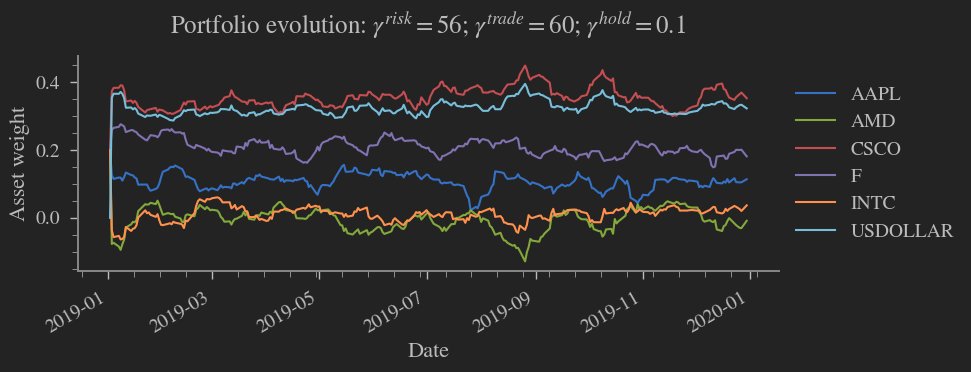

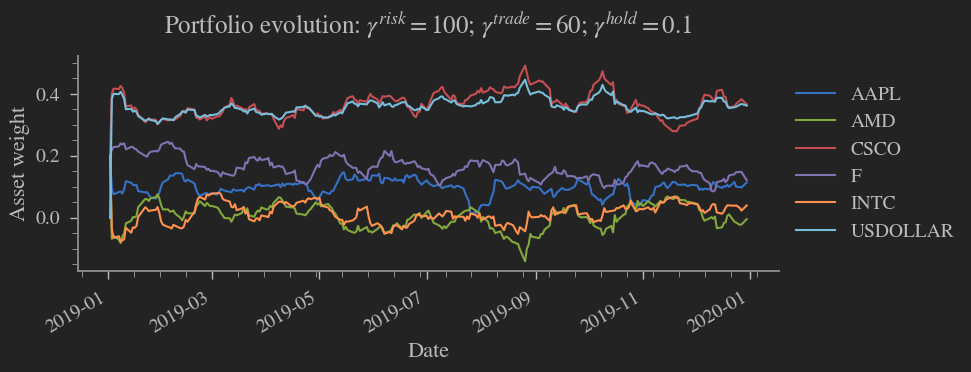

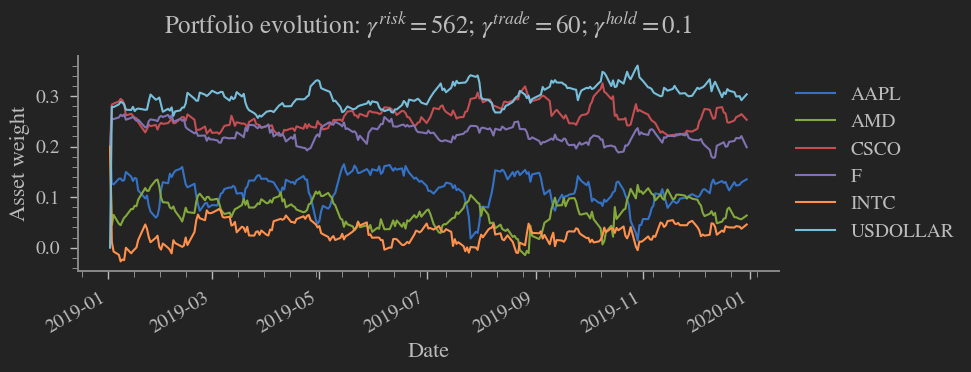

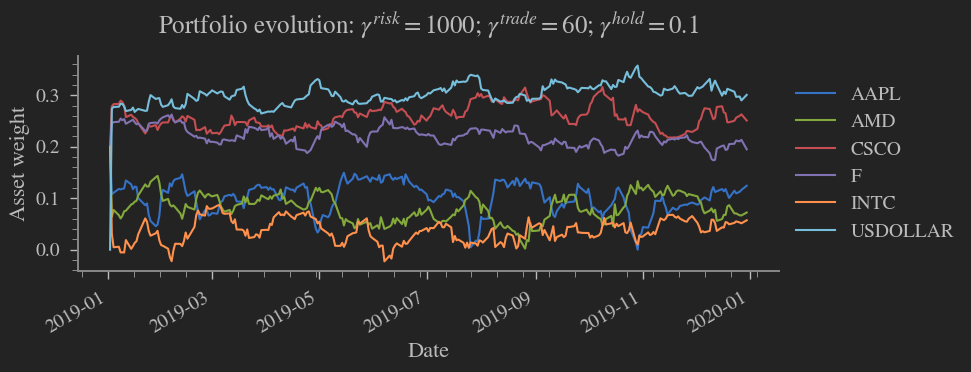

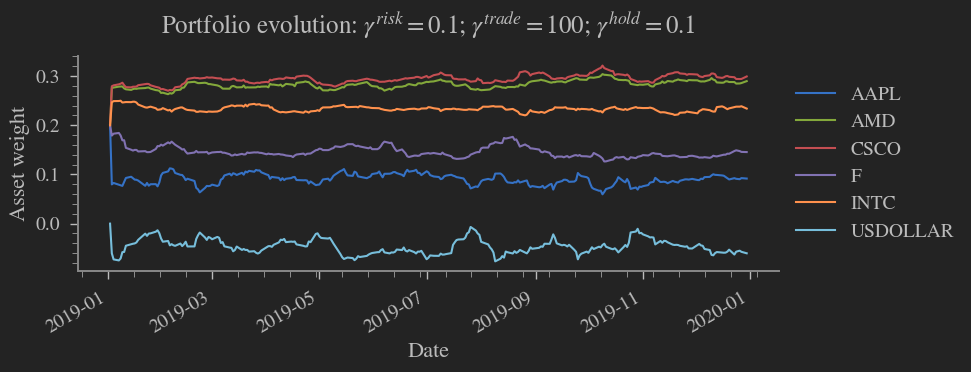

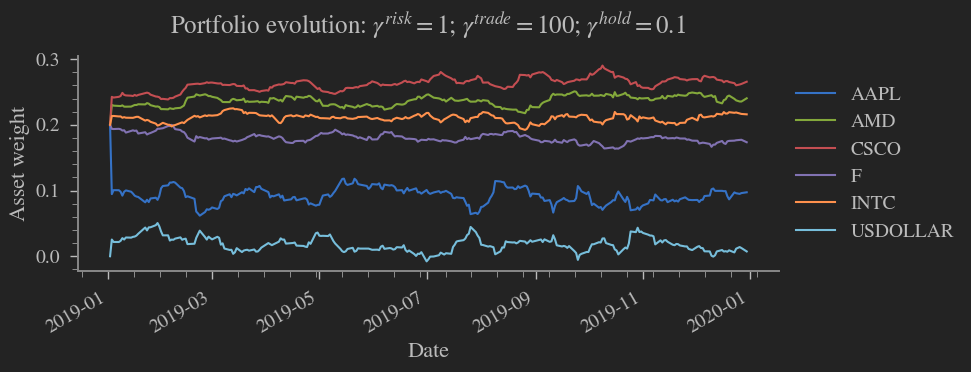

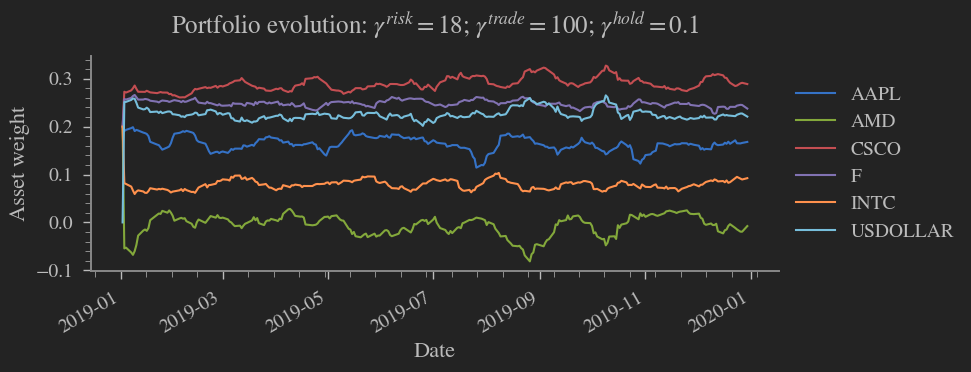

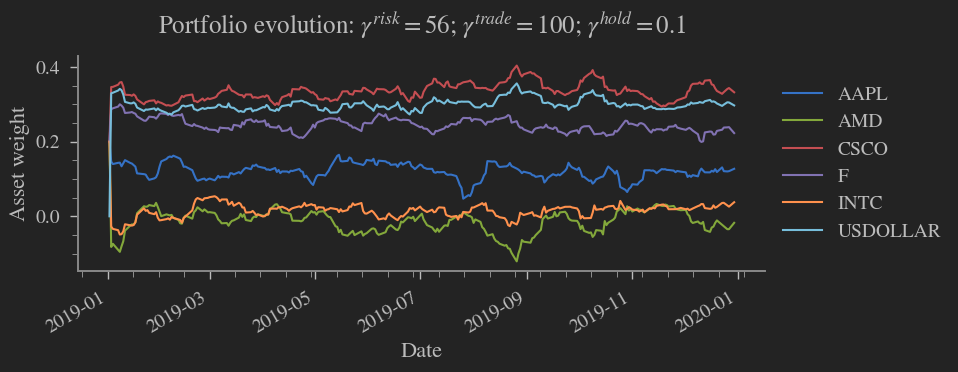

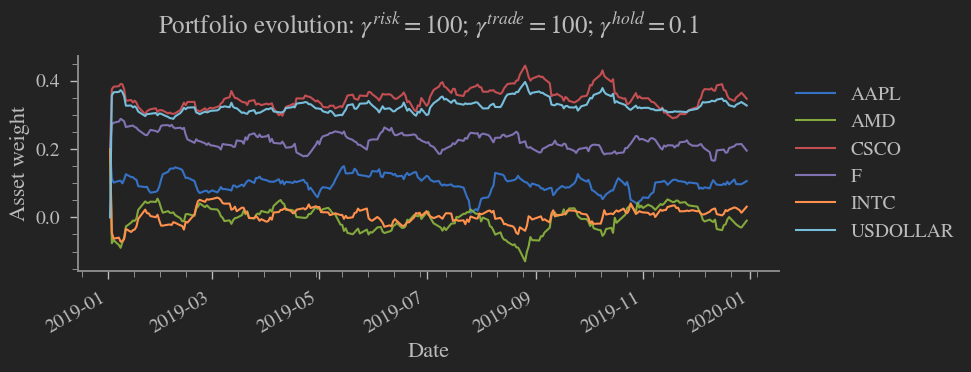

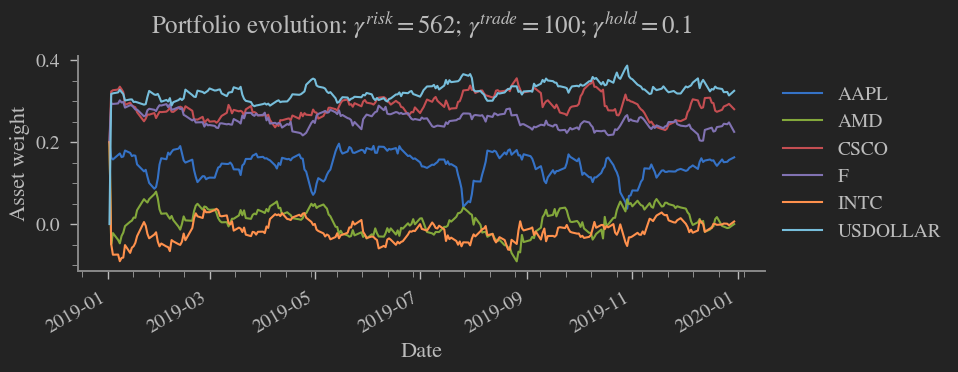

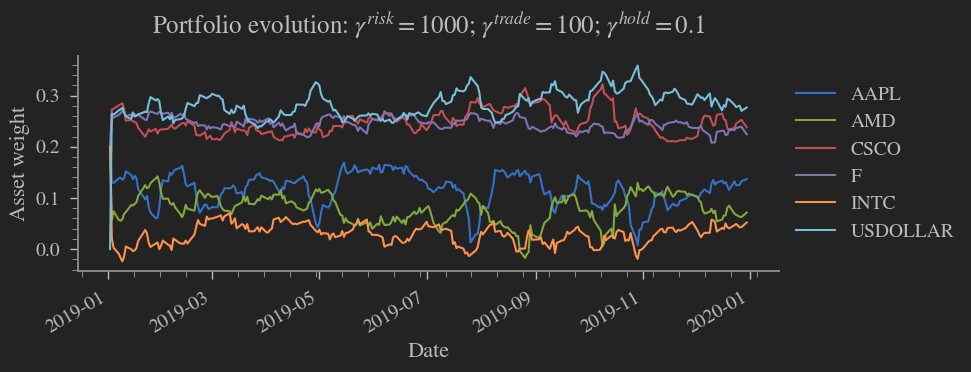

In [13]:
# plot actions for different gamma-tripples

#for RANDOM_SEED in SEED_LIST:
RANDOM_SEED = SEED_LIST[0]
for (GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD) in GAMMA_TRIPPPLES:
    # load actions
    actions_dir = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}/actions.csv'
    rl_actions = pd.read_csv(actions_dir, index_col=0, parse_dates=True)
    rl_actions.plot(figsize=(10,4), title=r'Portfolio evolution: $\gamma^{risk}=$'+f'{GAMMA_RISK}'+r'; $\gamma^{trade}=$'+f'{GAMMA_TRADE}'+r'; $\gamma^{hold}=$'+f'{GAMMA_HOLD}')
    plt.ylabel('Asset weight')
    # Put a legend to the right of the current axis
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [18]:
rl_actions.sum(axis=1)

Date
2019-01-02    1.0
2019-01-03    1.0
2019-01-04    1.0
2019-01-07    1.0
2019-01-08    1.0
             ... 
2019-12-23    1.0
2019-12-24    1.0
2019-12-26    1.0
2019-12-27    1.0
2019-12-30    1.0
Length: 251, dtype: float64

In [14]:
print(f'done backtesting for {MODEL_BASE_NAME}.')

done backtesting for RL_CNN.
